# Подготовка данных

## Настройка и загрузка датасета

In [1]:
from pathlib import Path
from vk_mod.data import load_dataset


SAMPLE_LIMIT:int = -1
datasets = [
    Path('../data/preprocessed/image_only.csv'),
    Path('../data/preprocessed/text_only.csv'),
    Path('../data/preprocessed/text-and-image.csv'),
    Path('../data/preprocessed/text-and-image-generated.csv')
]

images_dir = Path("..data/images")

df = load_dataset(datasets, sample_limit=SAMPLE_LIMIT)

c:\Users\ShapeCat\source\repos\ToxicPostDetection\.venv\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


## Статистика по распределению данных

In [2]:
has_text = df['text'].apply(lambda x: len(str(x).strip()) > 0)
has_image = df['image_name'].apply(lambda x: len(str(x).strip()) > 0)
print(f"""
      Статистика комбинаций данных:
      Текст: {len(df[has_text & ~has_image])}
      Картинка: {len(df[~has_text & has_image])}
      Текст+Картинка: {len(df[has_text & has_image])}
      Всего: {len(df)}
          """)
display(df.sample(10))


      Статистика комбинаций данных:
      Текст: 31158
      Картинка: 28443
      Текст+Картинка: 32000
      Всего: 91601
          


,text,image_name,blocked
8548,,e621_9023.png,1
25255,,e621_26625.png,1
76782,"Сотни людей сдаются, поскольку Исламское госуд...",1105591938885926912.jpg,0
2717,,e621_2852.png,1
1998,,e621_2104.png,1
13489,,e621_14238.png,1
72527,Смотреть: https://t.co/adBYXwwWKd Красивая дев...,1063917345171755008.jpg,0
59646,Счастливого Дня в мой рог 19! Love ya 4Life my...,1108422089000828928.jpg,1
62725,Челтенхэм 1.30 гоночная карта: Бегуны и гонщик...,1106543512949010434.jpg,0
86282,Straight Redneck at Work Cum Веб-камера https:...,1036190957278879744.jpg,1


## Формирование выборок

In [3]:
from sklearn.model_selection import train_test_split
from vk_mod.const import SEED


train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED)
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=SEED, shuffle=False)

# Обучение модели

## Создание модели

In [4]:
from vk_mod.models import  build_model
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 use_branch (USEBranch)         (None, 128)          68992896    ['text_input[0][0]']             
                                                                                                  
 data_presense (DataPresense)   (None, 1)            0           ['text_input[0][0]']         

## Обучение модели

In [ ]:
from vk_mod.models import train_model

model_path = Path("../models/model.keras")


model, history = train_model(model=model,
                             train_df=train_df,
                             val_df=test_df,
                             images_dir=images_dir,
                             epochs=100,
                             min_delta=0,
                             save_path=model_path
                             )

Epoch 1/100
2061/2061 [==============================] - 1622s 777ms/step - loss: 0.5739 - accuracy: 0.7376 - val_loss: 0.5213 - val_accuracy: 0.7660 - lr: 0.0010
Epoch 2/100
2061/2061 [==============================] - 1590s 771ms/step - loss: 0.5332 - accuracy: 0.7584 - val_loss: 0.5165 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 3/100
2061/2061 [==============================] - 1614s 783ms/step - loss: 0.5271 - accuracy: 0.7620 - val_loss: 0.5133 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 4/100
2061/2061 [==============================] - 1588s 771ms/step - loss: 0.5192 - accuracy: 0.7685 - val_loss: 0.5160 - val_accuracy: 0.7676 - lr: 0.0010
Epoch 5/100
2061/2061 [==============================] - 1656s 803ms/step - loss: 0.5112 - accuracy: 0.7727 - val_loss: 0.5129 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 6/100
2061/2061 [==============================] - 1930s 937ms/step - loss: 0.5054 - accuracy: 0.7774 - val_loss: 0.5250 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 7/100
2061/2061 

## График обучения

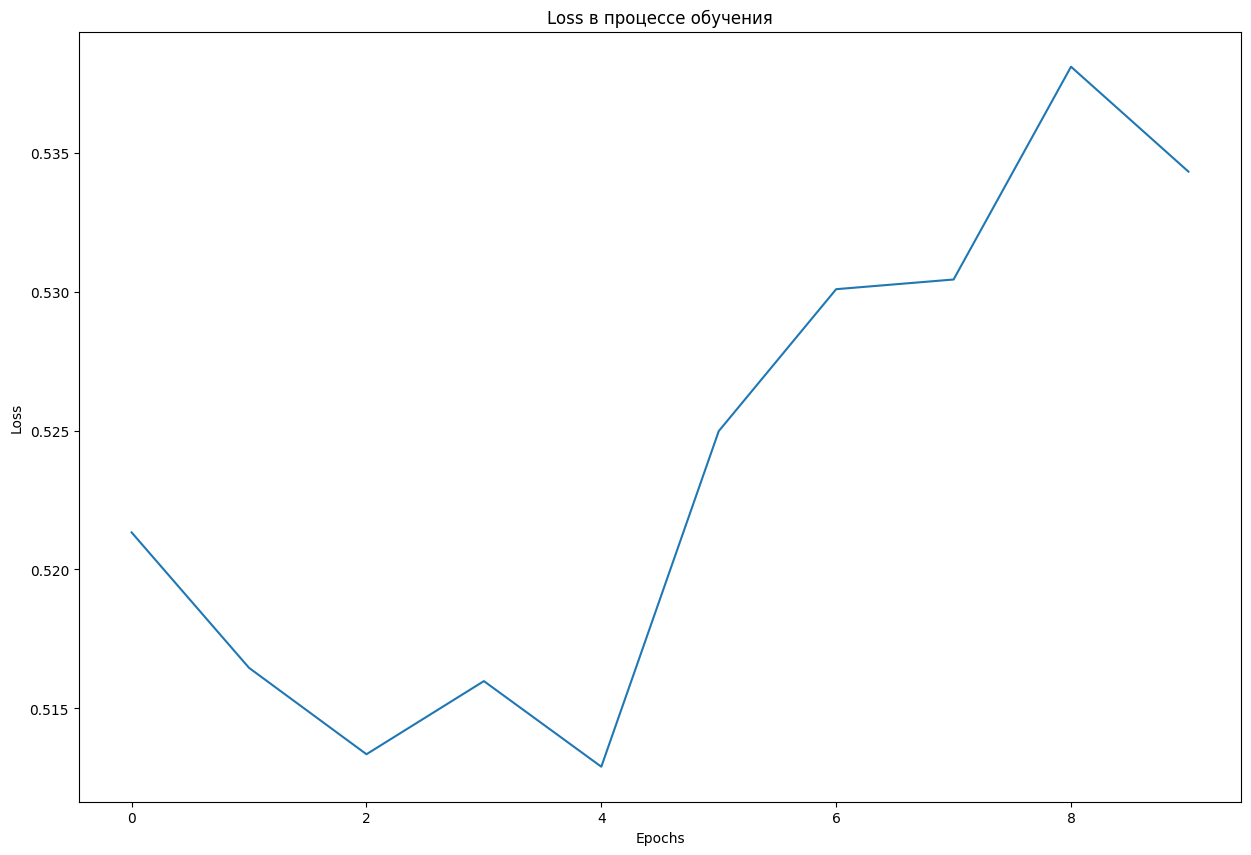

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(history.history['val_loss'])
plt.title('Loss в процессе обучения')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Оценка модели

## Метрики на разных комбинациях

In [7]:
from vk_mod.models import post_classifier

post_classifier.evaluate_data_combinations(model, val_df, images_dir)

Данные: Текст
197/197 [==============================] - 130s 661ms/step - loss: 0.3915 - accuracy: 0.8403
Данные: Картинка
177/177 [==============================] - 107s 602ms/step - loss: 0.5052 - accuracy: 0.8039
Данные: Текст и Изображение
200/200 [==============================] - 134s 670ms/step - loss: 0.6378 - accuracy: 0.6750
Данные: Весь набор
573/573 [==============================] - 368s 641ms/step - loss: 0.5126 - accuracy: 0.7714


# Тесты модели

## Проверка сохранения

In [22]:
from vk_mod.models import load_model

predict_after_training = post_classifier.predict_from_file(model, "это что за пиздец!?!!!!!", "e621_1.png")
print(f"After training: {predict_after_training} -> {predict_after_training > 0.5}")

model = load_model(model_path)
predict_after_reloading =  post_classifier.predict_from_file(model, "это что за пиздец!?!!!!!", "e621_1.png")
print(f"After reloading: {predict_after_reloading} -> {predict_after_reloading > 0.5}")

1/1 [==============================] - 0s 58ms/step
After training: 0.7895411252975464 -> True
1/1 [==============================] - 3s 3s/step
After reloading: 0.7895411252975464 -> True


## Искажения текста

In [9]:
post_classifier.predict_from_file(model, "это что за пи*дец!?!!!!!", "e621_1.png")

1/1 [==============================] - 0s 63ms/step


0.7848641

## Проверка картинки по url

In [10]:
post_classifier.predict_from_url(model, "", "https://sun9-35.userapi.com/impg/doJp2md6Q18pWWtXHNgeMxgbcWQ2qSwHKG-BPA/VkvhrKl89Vc.jpg?size=1280x1280&quality=95&sign=25cb6e551f5b588be0d9c4fb52e2e767&type=album")

1/1 [==============================] - 0s 66ms/step


0.8268175

## Контент одного характера

### Все положительное

In [ ]:
post_classifier.predict_from_url(model, "положительный текст", "https://sun9-35.userapi.com/impg/doJp2md6Q18pWWtXHNgeMxgbcWQ2qSwHKG-BPA/VkvhrKl89Vc.jpg?size=1280x1280&quality=95&sign=25cb6e551f5b588be0d9c4fb52e2e767&type=album")

1/1 [==============================] - 0s 58ms/step


0.8268175

### Все отрицательное

In [12]:
post_classifier.predict_from_url(model, "это что за пиздец!?!!!!!", "https://sun9-67.userapi.com/s/v1/ig2/G7NkuP8u8aI4U1J5gDiW2OhekcQwMmNrLffC3TiPVB-WAg9GlgMhmVMtKnkyr-0X1jhNYA_Ewqc1Vho0HU76yOG9.jpg?quality=95&as=32x32,48x48,72x72,108x108,160x160,240x240,360x360,480x480,540x540,640x640,720x720,1080x1080,1280x1280&from=bu&cs=1280x0")

1/1 [==============================] - 0s 61ms/step


0.726773

## Контент смешанного характера

### Положительный текст и отрицательная картинка

In [13]:
post_classifier.predict_from_url(model, "положительный текст", "https://sun9-67.userapi.com/s/v1/ig2/G7NkuP8u8aI4U1J5gDiW2OhekcQwMmNrLffC3TiPVB-WAg9GlgMhmVMtKnkyr-0X1jhNYA_Ewqc1Vho0HU76yOG9.jpg?quality=95&as=32x32,48x48,72x72,108x108,160x160,240x240,360x360,480x480,540x540,640x640,720x720,1080x1080,1280x1280&from=bu&cs=1280x0")

1/1 [==============================] - 0s 62ms/step


0.045106255

### Oтрицательная текст и положительная картинка

In [14]:
post_classifier.predict_from_url(model, "Что это за говно?!?!?!", "https://sun9-75.userapi.com/s/v1/if2/lP4YTYw5D4Ca1FYpQbgcZXhYQ-uI4Dv-Hg4TiYQ2l_9SDcqlpLqrqQQ5gCgjwmN0_sjj9YajX1BtDCdjP_hMVWmj.jpg?quality=96&as=32x24,48x36,72x54,108x81,160x120,240x180,360x270,480x360,540x405,640x480,720x540,1080x810,1280x960,1440x1080,2560x1920&from=bu&u=QCTk0zC8dlAqQg4g_uPSEn_dSMGvaqep7wUd5rG33y4&cs=807x605")

1/1 [==============================] - 0s 63ms/step


0.74552464